# Tutorial 4: Stereo-seq (mouse olfactory bulb)

This tutorial demonstrates how to identify spatial domains on the Stereo-seq platform.

In this tutorial, we foucs on the mouse olfactory bulb Stereo-seq data (https://github.com/JinmiaoChenLab/SEDR_analysiss). Before running the model, please download the input data via https://drive.google.com/drive/folders/1pV6u6U3JD8aTnBIGHEZdctZ0hZfWcBY1.

## Preparation

In [10]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import time
import stGCL as stGCL
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,refine_nearest_labels
os.environ['R_HOME'] = '/home/dell/anaconda3/envs/stjupyter/lib/R'
from stGCL import utils,train_model

In [28]:
section_id="Stereo-seq"
rad_cutoff = 70
k = 7
epoch = 1200
top_genes = 3000
use_image = False

In [12]:
adata = sc.read('/home/dell/stproject/stGCL/Data/Mouse_olfactory_bulb/adata.h5ad')
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=top_genes)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
prefilter_specialgenes(adata)

## Constructing the spatial network and Runging Model

In [13]:
utils.Cal_Spatial_Net(adata, rad_cutoff=rad_cutoff)

------Calculating spatial graph------
The graph contains 291130 edges, 19109 cells.
15.2352 neighbors per cell on average.
Neighbors information is stored in adata.uns["Spatial_Net"]


In [14]:
adata = train_model.train(adata,k,n_epochs=epoch,use_image=use_image)

train with no image
Epoch:100 loss:0.76813
Epoch:200 loss:0.73609
Epoch:300 loss:0.73307
Epoch:400 loss:0.73235
Epoch:500 loss:0.7366
Epoch:600 loss:0.7329
Epoch:700 loss:0.73296
Epoch:800 loss:0.7381
Epoch:900 loss:0.74862
Epoch:1000 loss:0.73212
Epoch:1100 loss:0.73201
Epoch:1200 loss:0.73242


In [15]:
adata = utils.mclust_R(adata, used_obsm='stGCL', num_cluster=k)
adata.obs["stGCL"] = adata.obs['mclust']

fitting ...
  |======================================================================| 100%


In [30]:
coor = pd.DataFrame(adata.obsm['spatial'])
coor.index = adata.obs.index
coor.columns = ['imagerow', 'imagecol']
adata.obs["x_pixel"]=coor['imagerow']
adata.obs["y_pixel"]=coor['imagecol']

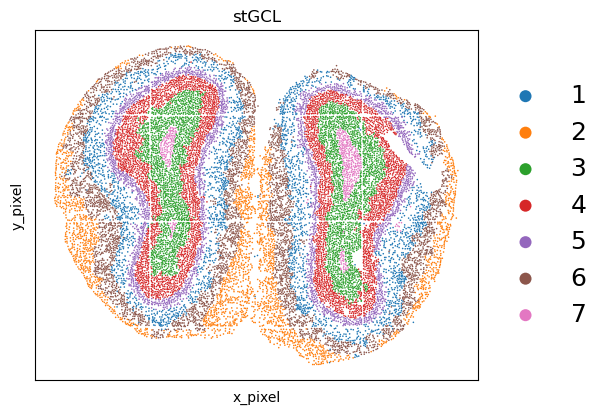

In [31]:
import matplotlib.pyplot as plt
title = "stGCL"
ax = sc.pl.scatter(adata, alpha=1, x="x_pixel", y="y_pixel", color="stGCL", legend_fontsize=18, show=False,title=title,
                   size=100000 / adata.shape[0])
ax.set_aspect('equal', 'box')
ax.set_xticks([])
ax.set_yticks([])
ax.axes.invert_yaxis()
plt.savefig("stGCL_{}.jpeg".format(section_id), dpi=600)